This code is an adaptation of Chris Gorgolewski's code for First Level analysis in FSL using nipype: 

https://github.com/poldrack/fmri-analysis-vm/blob/master/analysis/postFMRIPREPmodelling/First%20and%20Second%20Level%20Modeling%20(FSL).ipynb.  

The only difference with his code is that I've included the whole process into a workflow.

In [2]:
import nipype.pipeline.engine as pe 

import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting

%matplotlib inline
import matplotlib.pyplot as plt

datadir=os.path.abspath("./first_level_experiment/data/ds000114_R2.0.1/")
    
results_dir = os.path.abspath("./first_level_experiment/results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [3]:
def create_feat_first_level_wf(name="Feat1stLevel"):
    
    import nipype.pipeline.engine as pe 
    from nipype.interfaces import utility

    from nipype.algorithms import modelgen 
    from nipype.interfaces import fsl
    
    feat_first_level_wf = pe.Workflow(name=name)
    
    
    # Input Node- It collects the inputs
    inputNode = pe.Node(interface=utility.IdentityInterface(fields=["in_func",
                                                         "brain_mask",
                                                         "contrasts", 
                                                         "subject_info"]),
                     name = "inputSource")
    

    extractroi = pe.Node(fsl.ExtractROI(t_min=4, t_size=-1),
                         name = "extractRoi")
    
    feat_first_level_wf.connect(inputNode, "in_func", extractroi, "in_file")
    
    # SpecifyModel Node - It generates FSL-specific Model
    modelspec = pe.Node(modelgen.SpecifyModel(input_units='secs',
                                              time_repetition = 2.5,
                                              high_pass_filter_cutoff=128),
                     name="modelspec")
    
    feat_first_level_wf.connect(extractroi, "roi_file", modelspec, "functional_runs")
    feat_first_level_wf.connect(inputNode, "subject_info", modelspec, "subject_info")
        
    # Level1Design Node - It generates a FSL design matrix
    level1design = pe.Node(fsl.Level1Design(interscan_interval = 2.5,
                                            bases={'dgamma':{'derivs': True}},
                                            model_serial_correlations=True),
                        name="level1design")
    
    feat_first_level_wf.connect(inputNode, "contrasts", level1design, "contrasts")
    feat_first_level_wf.connect(modelspec, "session_info", level1design, "session_info")

    # Feat Node - It generates the 
    feat = pe.MapNode(fsl.FEATModel(), 
                   name="FEAT", iterfield=['fsf_file', 'ev_files'])
    
    feat_first_level_wf.connect([(level1design, feat, [("ev_files",  "ev_files"),
                                                  ("fsf_files",  "fsf_file")
                                                  ])
    ])
    
    # Mask_bold Node- It skullstrips the preprocessed bold image
    mask_bold = pe.Node(interface= fsl.maths.ApplyMask(),
                        name="mask_bold")
    
    feat_first_level_wf.connect(extractroi, "roi_file", mask_bold, "in_file")
    feat_first_level_wf.connect(inputNode, "brain_mask", mask_bold, "mask_file")
    
    # ModelEstimate Node- It fits the GLM and generates the contrast maps
    modelestimate = pe.MapNode(interface=fsl.FILMGLS(autocorr_noestimate = True),
                           name='modelestimate',
                           iterfield=['design_file', "tcon_file", "fcon_file"])
        
    feat_first_level_wf.connect(mask_bold, "out_file", modelestimate, "in_file")
    feat_first_level_wf.connect(feat, "design_file", modelestimate, "design_file")
    feat_first_level_wf.connect(feat, "con_file", modelestimate, "tcon_file")
    feat_first_level_wf.connect(feat, "fcon_file", modelestimate, "fcon_file")
    
    # Output Node - It collects the outputs
    outputNode = pe.Node(interface=utility.IdentityInterface(fields=["fstats",
                                                         "zstats",
                                                         "tstats",
                                                         "zfstats"]),
                     name = "outputSource")
    
    feat_first_level_wf.connect(modelestimate, "zstats", outputNode, "zstats")
    feat_first_level_wf.connect(modelestimate, "fstats", outputNode, "fstats")
    feat_first_level_wf.connect(modelestimate, "tstats", outputNode, "tstats")
    feat_first_level_wf.connect(modelestimate, "zfstats", outputNode, "zfstats")

    return feat_first_level_wf
   

In [4]:
from bids.layout import BIDSLayout
layout = BIDSLayout(datadir)
layout.get(suffix="bold", task="fingerfootlips", session="test", extension="nii.gz")[0].filename

'sub-01_ses-test_task-fingerfootlips_bold.nii.gz'

In [5]:
import pandas as pd
events = pd.read_csv(os.path.join(datadir, "task-fingerfootlips_events.tsv"), sep="\t")
events

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


In [6]:
for trial_type in events.trial_type.unique():
    print(events[events.trial_type == trial_type])

    onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger
    onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot
    onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips


In [7]:
events[events.trial_type == 'Finger'].duration

0     15.0
3     15.0
6     15.0
9     15.0
12    15.0
Name: duration, dtype: float64

In [8]:
source_epi = layout.get(suffix="bold", task="fingerfootlips", session="test", extension="nii.gz")[5]

confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                     "sub-%s"%source_epi.entities['subject'], 
                                     "ses-%s"%source_epi.entities['session'], "func", 
                                     "sub-%s_ses-%s_task-fingerfootlips_bold_confounds.tsv"%(source_epi.entities['subject'],
                                                                                             source_epi.entities['session'])),
           sep="\t", na_values="n/a")

info = [Bunch(conditions=['Finger',
                          'Foot',
                          'Lips'],
              onsets=[list(events[events.trial_type == 'Finger'].onset-10),
                      list(events[events.trial_type == 'Foot'].onset-10),
                      list(events[events.trial_type == 'Lips'].onset-10)],
              durations=[list(events[events.trial_type == 'Finger'].duration),
                          list(events[events.trial_type == 'Foot'].duration),
                          list(events[events.trial_type == 'Lips'].duration)],
             regressors=[list(confounds.FramewiseDisplacement.fillna(0)[4:]),
                         list(confounds.aCompCor0[4:]),
                         list(confounds.aCompCor1[4:]),
                         list(confounds.aCompCor2[4:]),
                         list(confounds.aCompCor3[4:]),
                         list(confounds.aCompCor4[4:]),
                         list(confounds.aCompCor5[4:]),
                        ],
             regressor_names=['FramewiseDisplacement',
                              'aCompCor0',
                              'aCompCor1',
                              'aCompCor2',
                              'aCompCor3',
                              'aCompCor4',
                              'aCompCor5',])
       ]

In [9]:
finger_cond = ['Finger','T', ['Finger'],[1]]
foot_cond = ['Foot','T', ['Foot'],[1]]
lips_cond = ['Lips','T', ['Lips'],[1]]
lips_vs_others = ["Lips vs. others",'T', ['Finger', 'Foot', 'Lips'],[-0.5, -0.5, 1]]
all_motor = ["All motor", 'F', [finger_cond, foot_cond, lips_cond]]
contrasts=[finger_cond, foot_cond, lips_cond, lips_vs_others, all_motor]

In [10]:
bold_mni = os.path.join(datadir, "derivatives", "fmriprep", 
                        "sub-%s"%source_epi.entities['subject'], 
                        "ses-%s"%source_epi.entities['session'], "func", 
                        "sub-%s_ses-%s_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"%(source_epi.entities['subject'], 
                                                                                                           source_epi.entities['session']))

In [11]:
mask_file = os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.entities['subject'], "ses-%s"%source_epi.entities['session'], "func", 
                                        "sub-%s_ses-%s_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz"%(source_epi.entities['subject'],
                                                                                                                             source_epi.entities['session']))

In [12]:
# Here we define the workflow object from the function defined at the beginning
feat_first_level_wf = create_feat_first_level_wf()
feat_first_level_wf.base_dir = "./first_level_experiment"

In [13]:
# Here we pass the needed inputs to the workflow
feat_first_level_wf.inputs.inputSource.in_func = bold_mni
feat_first_level_wf.inputs.inputSource.brain_mask = mask_file
feat_first_level_wf.inputs.inputSource.subject_info = info
feat_first_level_wf.inputs.inputSource.contrasts = contrasts

In [16]:
# Here we run the workflow
results = feat_first_level_wf.run()

190614-13:15:11,644 nipype.workflow INFO:
	 Workflow Feat1stLevel settings: ['check', 'execution', 'logging', 'monitoring']
190614-13:15:11,659 nipype.workflow INFO:
	 Running serially.
190614-13:15:11,661 nipype.workflow INFO:
	 [Node] Setting-up "Feat1stLevel.extractRoi" in "/home/javier/Downloads/first_level_experiment/Feat1stLevel/extractRoi".
190614-13:15:11,665 nipype.workflow INFO:
	 [Node] Running "extractRoi" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /home/javier/Downloads/first_level_experiment/data/ds000114_R2.0.1/derivatives/fmriprep/sub-06/ses-test/func/sub-06_ses-test_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc.nii.gz /home/javier/Downloads/first_level_experiment/Feat1stLevel/extractRoi/sub-06_ses-test_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc_roi.nii.gz 4 -1
190614-13:15:18,516 nipype.workflow INFO:
	 [Node] Finished "Feat1stLevel.extractRoi".
190614-13:15:18,517 nipype.workflow INFO:
	 [Node]

In [17]:
# Here we pick the results from the Feat Node
import pickle
import gzip

feat_node_results_pkl = gzip.open("/home/javier/Downloads/first_level_experiment/Feat1stLevel/FEAT/result_FEAT.pklz",'rb')
feat_node_results = pickle.load(feat_node_results_pkl)

In [18]:
# NO DESIGN MATRIX IMAGE GENERATED!!!!
feat_node_results.outputs

Bunch(con_file=['/home/javier/Downloads/first_level_experiment/Feat1stLevel/FEAT/mapflow/_FEAT0/run0.con'],
      design_cov=<undefined>,
      design_file=['/home/javier/Downloads/first_level_experiment/Feat1stLevel/FEAT/mapflow/_FEAT0/run0.mat'],
      design_image=<undefined>,
      fcon_file=['/home/javier/Downloads/first_level_experiment/Feat1stLevel/FEAT/mapflow/_FEAT0/run0.fts'])

In [19]:
# Here we pick the results from the ModelEstimate Node, which contains the contrast maps
filmgls_results_pkl = gzip.open("/home/javier/Downloads/first_level_experiment/Feat1stLevel/modelestimate/result_modelestimate.pklz",'rb')
filmgls_results = pickle.load(filmgls_results_pkl)

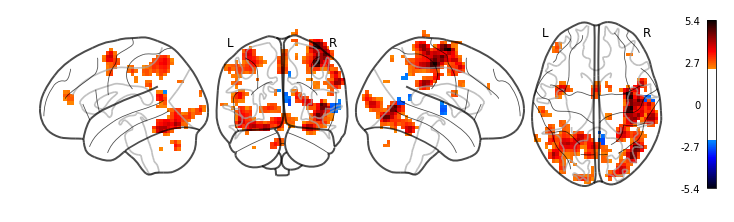

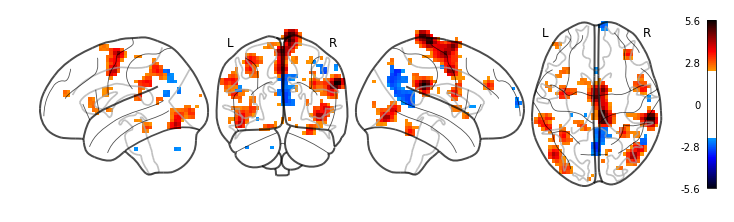

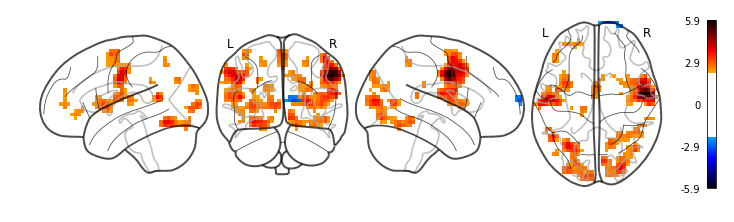

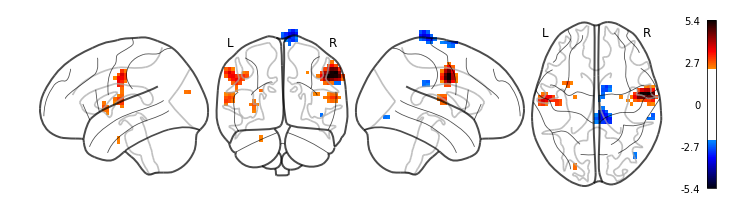

In [20]:
for t_map in filmgls_results.outputs.zstats[0]:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

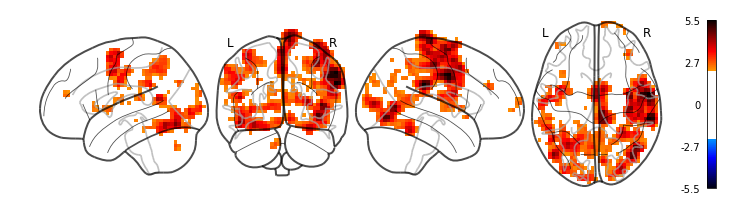

In [21]:
for t_map in filmgls_results.outputs.zfstats:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

In [118]:
# In contrast to Chris' notebook, here no copes are generated!!!
for t_map in filmgls_results.outputs.copes[0]:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, vmax=30)

TypeError: '_Undefined' object is not subscriptable

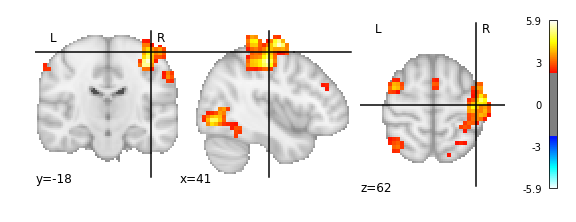

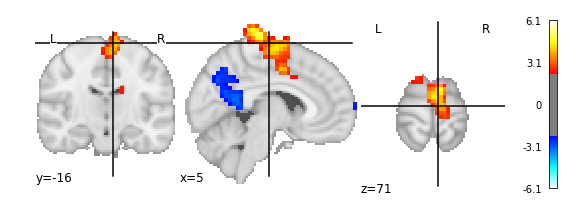

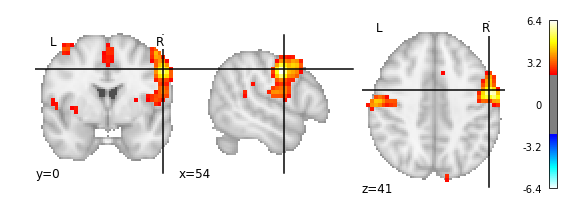

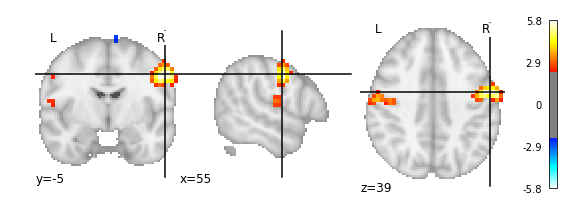

In [22]:
for t_map in filmgls_results.outputs.tstats[0]:
    nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(t_map, 8), colorbar=True, threshold=2.3)